In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u
from copy import deepcopy

from multiprocessing import Pool
from sigmacut import calcaverageclass

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

corrections = np.loadtxt('ps1_calspec_cor.txt')
calsources = pd.read_csv('../calibration/calspec_full.csv')

In [15]:
syn = np.load('cal_mags/caspec_mags_skymapper.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)
syn = syn.rename(columns={'SkyMapper.u':'u','SkyMapper.v':'v','SkyMapper.g':'g',
                          'SkyMapper.r':'r','SkyMapper.i':'i','SkyMapper.z':'z'})

synt = np.load('cal_mags/caspec_mags_moa.npy',allow_pickle=True).item()
synt = pd.DataFrame(synt)
syn['moa_R'] = synt['moa_R'].values

In [48]:
syn = np.load('cal_mags/caspec_mags_skymapper.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)
syn = syn.rename(columns={'SkyMapper.u':'u','SkyMapper.v':'v','SkyMapper.g':'g',
                          'SkyMapper.r':'r','SkyMapper.i':'i','SkyMapper.z':'z'})

synt = np.load('current_caspec_mags.npy',allow_pickle=True).item()
synt = pd.DataFrame(synt)
syn['tess'] = synt['tess'].values

good = []
for i in range(len(syn['name'])):
    if 'ngc6681' not in syn['name'].iloc[i]:
        good += [i]
good = np.array(good)
syn = syn.iloc[good]
gr = syn['g'].values-syn['r'].values
ind = (gr < .6) #& (gr >= 0.2)
syn = syn.iloc[ind]

In [43]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux

def t_comp(c,mag):
    zp = 25
    g = mag2flux(mag['g'].values,zp)
    r = mag2flux(mag['r'].values,zp)
    i = mag2flux(mag['i'].values,zp)
    z = mag2flux(mag['z'].values,zp)
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y + c[5]*(g-r)
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z)*(g/i)**c[4]
    if np.nansum(fit) == 0:
        return 1e5
    fit = -2.5*np.log10(fit) + zp
    return fit 

def t_minimizer(c,mag):
    print(c)
    k = mag['moa_R'].values
    fit = t_comp(c,mag)
    diff = abs(k-fit)
    #print(diff)
    res = np.nansum(diff)
    #print(res)
    return res


In [44]:
c0 = [0,0.1,0.1,0.1,0.01]
#c0 = [.25,.25,.25,.25,1]
bds = [(0,2),(0,2),(0,2),(0,2),(-100,100)]
res = minimize(t_minimizer,c0,args=(syn),bounds=bds)

[0.   0.1  0.1  0.1  0.01]
[1.e-08 1.e-01 1.e-01 1.e-01 1.e-02]
[0.         0.10000001 0.1        0.1        0.01      ]
[0.         0.1        0.10000001 0.1        0.01      ]
[0.         0.1        0.1        0.10000001 0.01      ]
[0.         0.1        0.1        0.1        0.01000001]
[  0.           0.           0.           0.         -17.48859848]
[ 1.00000000e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.74885985e+01]
[ 0.00000000e+00  1.00000000e-08  0.00000000e+00  0.00000000e+00
 -1.74885985e+01]
[ 0.00000000e+00  0.00000000e+00  1.00000000e-08  0.00000000e+00
 -1.74885985e+01]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-08
 -1.74885985e+01]
[  0.           0.           0.           0.         -17.48859847]
[ 0.          0.06666572  0.06666572  0.06666572 -5.82303224]
[ 1.00000000e-08  6.66657176e-02  6.66657176e-02  6.66657176e-02
 -5.82303224e+00]
[ 0.          0.06666573  0.06666572  0.06666572 -5.82303224]
[ 0.          0.06666572  0.0666657

In [45]:
res.x

array([ 0.00865918,  0.        ,  0.        ,  0.03772349, -1.20257294])

In [46]:
test = t_comp(res.x,syn)
#test = r_comp(mc,syn)
kdiff = syn['moa_R']-test
gr = syn['g'].values-syn['r'].values
mask = ~sigma_clip(kdiff).mask
kdiff = kdiff[mask]

<IPython.core.display.Javascript object>


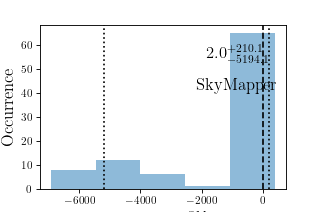

Text(0, 0.5, 'Occurrence')

In [47]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(kdiff) - np.nanmin(kdiff) /(2*iqr(kdiff)*len(kdiff)**(-1/3)))
plt.hist(kdiff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(kdiff*1e3,50)
low = np.percentile(kdiff*1e3,16)
high = np.percentile(kdiff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(abs((np.round(med,0))))+'^{+' + str((np.round(high-med,1)))+'}_{'+str((np.round(low-med,1)))+'}$'
plt.annotate(s,(.8,.8),fontsize=15,xycoords='axes fraction', ha='center')
plt.annotate('SkyMapper',(.80,.6),fontsize=15,xycoords='axes fraction', ha='center')

plt.xlabel(r'$TESS_{cal}-TESS^{SM}_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
#plt.savefig('SM_com_tess_res.pdf', bbox_inches = "tight")

<IPython.core.display.Javascript object>


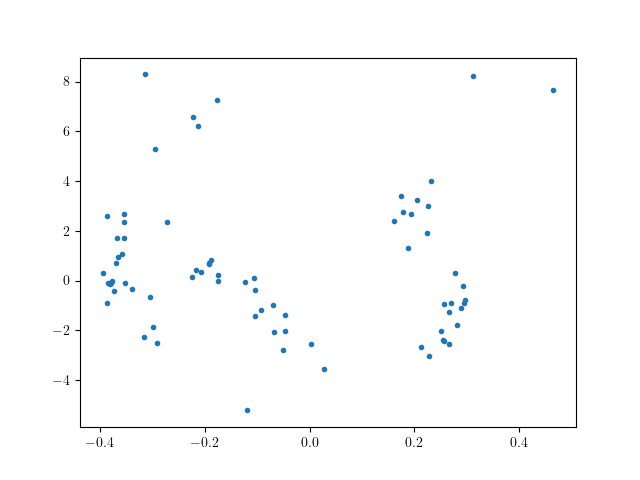

In [99]:
plt.figure()
plt.plot(gr[mask],kdiff*1e3,'.')

In [102]:
np.nansum((kdiff)**2/np.std(kdiff)**2)/len(test)

0.924969395319366

# Example spec plot

In [23]:
from tools import *
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]

model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)

pbnames = ['SkyMapper.u','SkyMapper.v','SkyMapper.g','SkyMapper.r','SkyMapper.i','SkyMapper.z']
model_mags = 0.
model = 'AB'
skypbs = source_synphot.passband.load_pbs(pbnames, model_mags, model,SVO=True)

SVO
SVO
SVO
SVO
SVO
SVO


In [24]:
from glob import glob
path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

In [25]:
skypbs

OrderedDict([('SkyMapper.u',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa6692823d0>,
               -20.12409896252752)),
             ('SkyMapper.v',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa6685b7b50>,
               -20.327234802859447)),
             ('SkyMapper.g',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa5fc7e5110>,
               -20.93514594320294)),
             ('SkyMapper.r',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa5fc7f3c50>,
               -21.348172814238747)),
             ('SkyMapper.i',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa5fc77e490>,
               -21.859422074442367)),
             ('SkyMapper.z',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7fa5fc7701d0>,
               -22.214036934931404))])

<IPython.core.display.Javascript object>


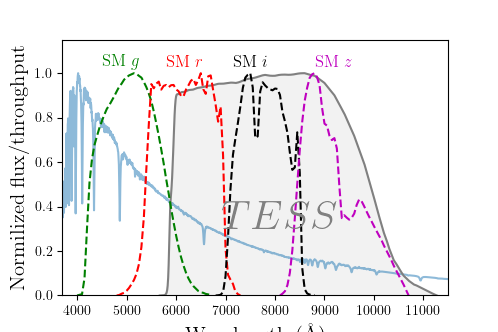

In [76]:
spec = np.loadtxt(files[86],skiprows=1,delimiter=',')

plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(spec[:,0],spec[:,1]/np.nanmax(spec[:,1]),alpha=.5,label='SDSS spectra')
#ax = plt.gca().twinx()
plt.fill_between(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='k',alpha=0.05)
plt.plot(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='grey',label='$TESS$')
plt.text(6900,0.3,'$TESS$',color='grey',fontsize=30)


#plt.plot(skypbs['SkyMapper.u'][0].wave,skypbs['SkyMapper.u'][0].throughput/np.nanmax(skypbs['SkyMapper.u'][0].throughput),'c--',label='u')
plt.plot(skypbs['SkyMapper.g'][0].wave,skypbs['SkyMapper.g'][0].throughput/np.nanmax(skypbs['SkyMapper.g'][0].throughput),'g--',label='g')
plt.plot(skypbs['SkyMapper.r'][0].wave,skypbs['SkyMapper.r'][0].throughput/np.nanmax(skypbs['SkyMapper.r'][0].throughput),'r--',label='r')
plt.plot(skypbs['SkyMapper.i'][0].wave,skypbs['SkyMapper.i'][0].throughput/np.nanmax(skypbs['SkyMapper.i'][0].throughput),'k--',label='i')
plt.plot(skypbs['SkyMapper.z'][0].wave,skypbs['SkyMapper.z'][0].throughput/np.nanmax(skypbs['SkyMapper.z'][0].throughput),'m--',label='z')

#plt.plot(pbs['ps1r'][0].wave,pbs['ps1r'][0].throughput/np.nanmax(pbs['ps1r'][0].throughput),'r--',label='PS1 r')
#plt.plot(pbs['ps1i'][0].wave,pbs['ps1i'][0].throughput/np.nanmax(pbs['ps1i'][0].throughput),ls='--',color='k',label='PS1 i')
#plt.plot(pbs['ps1z'][0].wave,pbs['ps1z'][0].throughput/np.nanmax(pbs['ps1z'][0].throughput),ls='--',color='m',label='PS1 z')
#plt.plot(pbs['ps1y'][0].wave,pbs['ps1y'][0].throughput/np.nanmax(pbs['ps1y'][0].throughput),ls='--',color='sienna',label='PS1 y')

plt.text(4500,1.03,'SM $g$',color='g',fontsize=12)
plt.text(5800,1.03,'SM $r$',color='r',fontsize=12)
plt.text(7150,1.03,'SM $i$',color='k',fontsize=12)
plt.text(8800,1.03,'SM $z$',color='m',fontsize=12)
#plt.text(9200,1.03,'PS1 $y$',color='sienna',fontsize=12)

#plt.legend(ncol=1, bbox_to_anchor=(1.01, .8))
#plt.legend(ncol=4,loc='center', bbox_to_anchor=(.5, 1.1))
plt.xlim(3700,11500)
plt.ylim(0,1.15)

plt.xlabel(r'Wavelength $(\rm \AA)$',fontsize=15)
plt.ylabel('Normilized flux/throughput',fontsize=15)
plt.savefig('calspec_spec_example_tess_SM.pdf', bbox_inches = "tight")

In [5]:
gaia = np.loadtxt('/Users/rridden/Documents/work/data/filters/gaia/GAIA_GAIA0.G.dat')

In [17]:
gaia.shape

(362, 2)

<IPython.core.display.Javascript object>


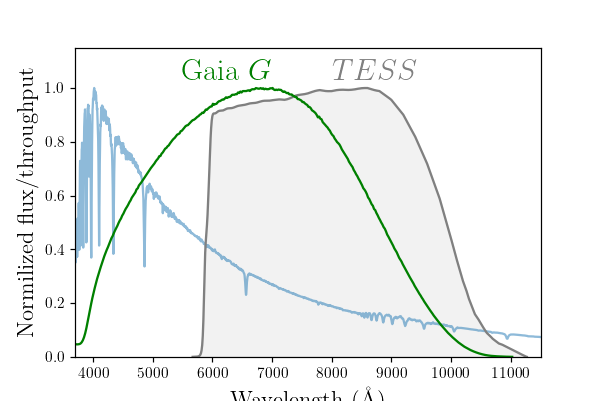

In [33]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(spec[:,0],spec[:,1]/np.nanmax(spec[:,1]),alpha=.5,label='SDSS spectra')
plt.fill_between(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='k',alpha=0.05)
plt.plot(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='grey',label='$TESS$')
plt.text(8000,1.03,'$TESS$',color='grey',fontsize=20)

plt.plot(gaia[:,0],gaia[:,1],'g')
plt.text(5500,1.03,'Gaia $G$',color='g',fontsize=20)


plt.xlim(3700,11500)
plt.ylim(0,1.15)

plt.xlabel(r'Wavelength $(\rm \AA)$',fontsize=15)
plt.ylabel('Normilized flux/throughput',fontsize=15)
plt.savefig('calspec_spec_gaia_tess.pdf', bbox_inches = "tight")